&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&ensp;
[Home Page](../Start_Here.ipynb)


[Previous Notebook](Part2.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[1](Start_Here.ipynb)
[2](Part2.ipynb)
[3]
[4](Part4.ipynb)
[5](Competition.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[Next Notebook](Part4.ipynb)





# Steady State Flow Using Neural Networks - Part 3

**Contents of the this notebook:**

- [Improving Our Fully Connected Model](#Building-our-First-Model)
- [Building a Convolutional Model](#Convolutional-model)
- [Input Data Manipulation](#Input-Data-Manipulation)

**By the End of this notebook participants will:**

- Benchmark three different models and their performance
- Understand how input data manipulation can help in building a better model.

# Improving our Fully Connected Network

Let us import libraries, dataset and define the Loss function 

In [1]:
# Importing Necessary Libraries 
from __future__ import print_function

import sys
sys.path.append('/workspace/python/source_code')

import numpy as np
import utils.data_utils as data_utils
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import math
import matplotlib.pyplot as plt

import time

import importlib

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# reload(data_utils) # you need to execute this in case you modify the plotting scripts in data_utils

In [2]:
batch_size = 8
dataset_size = 1500   # Number of elements in the train.tfrecords
validation_size = 256 # Number of elements to use for validation

# derive some quantities
train_size = dataset_size - validation_size
train_batches = int(train_size / batch_size)
validation_batches= int(validation_size / batch_size)

test_size = 28
test_batches = int(test_size/batch_size)
print('Number of batches in train/validation/test dataset:', train_batches, '/', validation_batches, '/', test_batches)

def init_datasets():
    dataset = tf.data.TFRecordDataset('data/train.tfrecords')
    dataset = dataset.take(dataset_size)
    # Transform binary data into image arrays
    dataset = dataset.map(data_utils.parse_flow_data)
    
    training_dataset = dataset.skip(validation_size).shuffle(buffer_size=512)
    training_dataset = training_dataset.batch(batch_size, drop_remainder=True)
    training_dataset = training_dataset.repeat()

    validation_dataset = dataset.take(validation_size).batch(batch_size, drop_remainder=True)
    validation_dataset = validation_dataset.repeat()

    # Read test dataset
    test_dataset = tf.data.TFRecordDataset('data/test.tfrecords')
    test_dataset = test_dataset.map(data_utils.parse_flow_data) # Transform binary data into image arrays
    test_dataset = test_dataset.batch(batch_size, drop_remainder = True).repeat()
 
    return training_dataset, validation_dataset, test_dataset

training_dataset, validation_dataset, test_dataset = init_datasets()

Number of batches in train/validation/test dataset: 155 / 32 / 3


input shape: [8, 128, 256, 1]
output shape: [8, 128, 256, 2]


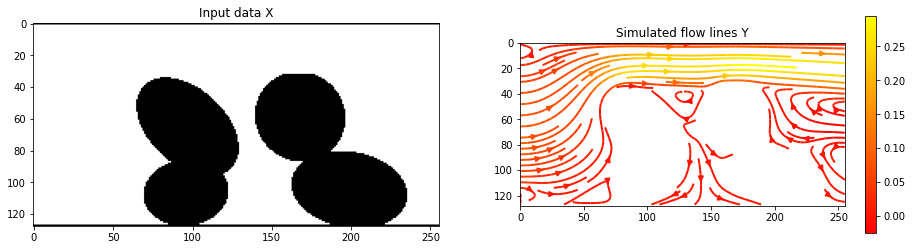

In [3]:
# Create an iterator for reading a batch of input and output data
iterator = iter(training_dataset)
boundary, vflow = next(iterator)

print('input shape:', boundary.shape.as_list())
print('output shape:', vflow.shape.as_list())

plot_idx = 3 # set it between 0 and batch_size

data_utils.plot_flow_data(boundary[plot_idx,:,:,:], vflow[plot_idx,:,:,:])

In [4]:
def loss_image(vflow_hat, vflow):
    ''' Defines the loss for the predicted flow.
    
    Arguments:
    vflow_hat -- predicted flow, shape (?, nh, nw, 2)
    vflow   -- target flow from the simulation, shape (?, nh, nw, 2)
    
    Returns: the L2 loss
    '''
    ### define the squure error loss (~ 1 line of code)
    loss = tf.nn.l2_loss(vflow_hat - vflow)
    ###
                         
    # Add a scalar to tensorboard
    tf.summary.scalar('loss', loss)
    
    return loss

### Model 

5 - Layer Fully Connected Network : 

* Input Layer of Size ( 128 * 256 * 1 )
* Hidden Layer of Size ( 1024 ) 
* Hidden Layer of Size ( 1024 ) 
* Hidden Layer of Size ( 1024 ) 
* Output Layer of Size ( 128 * 256 * 2 ) 


In [5]:
def fully_connected(input):
    # Arguments:
    # input -- input layer for the network, expected shape (?,nh,nw,1)
    # Returns -- predicted flow (?, nh, nw, 2)
    
    nh = K.int_shape(input)[1]
    nw = K.int_shape(input)[2]
    
    # define the hidden layers
    x = layers.Flatten()(input)
    
     
    ### Add three dense hidden layers with 1024 hidden units each
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)
    ##
   
    x = layers.Dense(nh*nw*2, activation='relu')(x)
    output = layers.Reshape((nh,nw,2))(x)
    ###
    
    return output

In [6]:
input = tf.keras.Input(shape=(128,256,1))
output = fully_connected(input)


### Define a new keras model with the above input and output, and compile it with Adam optimizer
fc_model = tf.keras.Model(inputs = input, outputs=output)
fc_model.compile(tf.keras.optimizers.Adam(0.0001), loss=loss_image)
###
fc_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 256, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 65536)             67174400  
_________________________________________________________________
reshape (Reshape)            (None, 128, 256, 2)       0     

In [7]:
!mkdir -p ./tmp/fc3

history = fc_model.fit(training_dataset, epochs=30, steps_per_epoch=train_batches,
          validation_data=validation_dataset, validation_steps=validation_batches, 
            callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/fc3')])

Epoch 1/30
155/155 [==============================] - 16s 24ms/step - loss: 429.6667 - val_loss: 218.6213
Epoch 2/30
155/155 [==============================] - 3s 17ms/step - loss: 191.4026 - val_loss: 181.2743
Epoch 3/30
155/155 [==============================] - 3s 17ms/step - loss: 165.2752 - val_loss: 167.9348
Epoch 4/30
155/155 [==============================] - 3s 17ms/step - loss: 151.8431 - val_loss: 160.3818
Epoch 5/30
155/155 [==============================] - 3s 17ms/step - loss: 145.2515 - val_loss: 152.1679
Epoch 6/30
155/155 [==============================] - 3s 17ms/step - loss: 134.3197 - val_loss: 148.9689
Epoch 7/30
155/155 [==============================] - 3s 17ms/step - loss: 134.7589 - val_loss: 144.5698
Epoch 8/30
155/155 [==============================] - 3s 17ms/step - loss: 128.2479 - val_loss: 141.7893
Epoch 9/30
155/155 [==============================] - 3s 17ms/step - loss: 122.0814 - val_loss: 138.8566
Epoch 10/30
155/155 [==============================] -

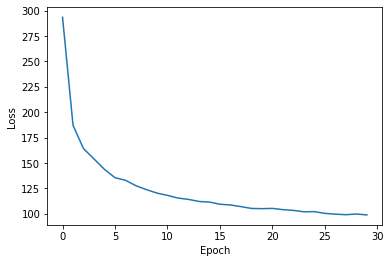

In [8]:
# Let us Plot the train History
data_utils.plot_keras_loss(history)

### Test

We will evaluate the model on the test dataset, and plot some of the results.

In [9]:
test_loss = fc_model.evaluate(test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 0s 6ms/step - loss: 82.4291
The loss over the test dataset 82.42911529541016


/workspace/python/source_code/utils/data_utils.py:45: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  stream_flow = h5py.File(filename)


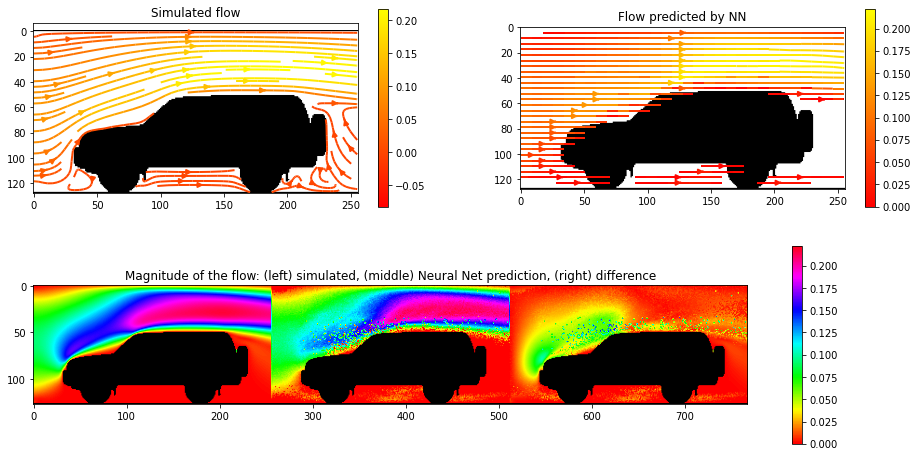

In [10]:
x, vxy = data_utils.load_test_data(1) # you can try different numbers between 1 and 28
vxy_hat = fc_model.predict(x)
data_utils.plot_test_result(x, vxy, vxy_hat)

We can plot a vertical slice of the velocity field for better comparison

Text(0, 0.5, 'vy')

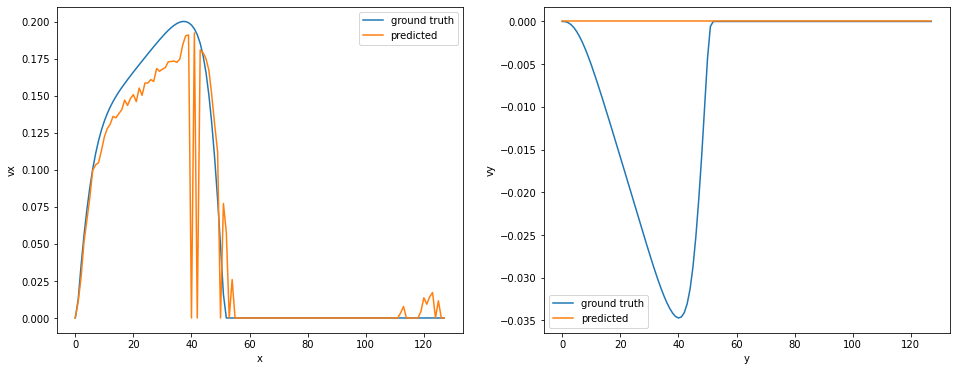

In [11]:
x_idx=120 # x coordinate for the slice

vx = np.squeeze(vxy[0,:,x_idx,0])                 # test velocity fields
vy = np.squeeze(vxy[0,:,x_idx,1])

vx_hat = np.squeeze(vxy_hat[0,:,x_idx,0])         # predicted velocity field
vy_hat = np.squeeze(vxy_hat[0,:,x_idx,1])

fig = plt.figure(figsize=(16,6))

# plot the x component of the velocity
ax = fig.add_subplot(121)
ax.plot(vx, label='ground truth')
ax.plot(vx_hat, label='predicted')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('vx')

# plot the y component of the velocity
ax = fig.add_subplot(122)
ax.plot(vy, label='ground truth')
ax.plot(vy_hat, label='predicted')
ax.legend()
ax.set_xlabel('y')
ax.set_ylabel('vy')


We have bbserved the decrease in the loss function but it is still not sufficient for practical purposes. Let us now define a Convolution Model and see how it performs.

## Convolutional model
We will re-create the network from [Convolutional Neural Networks for Steady Flow Approximation](https://www.autodeskresearch.com/publications/convolutional-neural-networks-steady-flow-approximation). Here is an illustration from the paper: <img src='images/convnet.png' width='800px'>

The number of filters and the kernel size are shown below for the conv/deconv operations. The dimension of the feature maps is indicated below in the boxes. The strides are the same as the kernel sizes.

The direct connection between the input and the output layers is just a multiplication that zeros the flow inside the objects.

To Learn about Convolutional Neural Networks and how they work, visit [Convolution Neural Network Notebook](../Intro_to_DL/CNN's.ipynb)

### Model

We define the encoding/decoding part separately, and then we combine them.

We will set the parameters for [conv2d](https://keras.io/layers/convolutional/#conv2d), and add the fully connected layer

In [12]:
def conv(input):
    # Define layers to calculate the convolution and FC part of the network
    # Arguments:
    # input -- (?, nh, nw, nc)
    # Returns: (? 1,1,1024)
    
    
    ### Set the number of filters for the first convolutional layer
    x = layers.Conv2D(128, (16,16), strides=(16,16), padding='same', name='conv1', activation='relu')(input)
    
    
    ### Set the number of filters and kernel size for the second convolutional layer 
    x = layers.Conv2D(512, (4,4), strides=(4,4), padding='same', name='conv2', activation='relu')(x)
    ###
    
    x = layers.Flatten()(x)
    
    
    ### Add a denslayer with ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    ###
    
    # Reshape the output as 1x1 image with 1024 channels:
    x = layers.Reshape((1,1,1024))(x)
    
    return(x)

We define one of the decoding branch using [Conv2DTranspose](https://keras.io/layers/convolutional/#conv2dtranspose)

In [13]:
def deconv(input, suffix):
    # Define layers that perform the deconvolution steps
    # Arguments:
    # input -- (?, 1, 1, 1024)
    # suffix -- name_suffix
    # Returns -- (?,128,256,1)
    x = layers.Conv2DTranspose(512, (8,8), strides=(8,8), activation='relu', name="deconv1_"+suffix)(input)
    
    
    ### Add the 2nd and 3rd Conv2DTranspose layers
    x = layers.Conv2DTranspose(256, (8,4), strides=(8,4), activation='relu', name="deconv2_"+suffix)(x)
    x = layers.Conv2DTranspose(32, (2,2), strides=(2,2), activation='relu', name="deconv3_"+suffix)(x)
    ###
    
    x = layers.Conv2DTranspose(1, (2,2), strides=(2,2), activation='relu', name="deconv4_"+suffix)(x)
    x = layers.Permute((2,1,3))(x)
    return x

In [14]:
def conv_deconv(input):
    # Combine the convolution / deconvolution steps
    x = conv(input)
    
    vx = deconv(x, "vx")
    
    # create a mask to zero out flow at (and inside) the boundary 
    vx = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_vx')([vx, input])
    
     
    ### Add decoder for vy
    vy = deconv(x, "vy")
    ### 
    
    vy = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_vy')([vy, input])
    
    output = layers.concatenate([vx, vy], axis=3)
    
    return output

Compile the model:

In [15]:
K.clear_session()

# we need to re-init the dacaset because of Clearing our session
training_dataset, validation_dataset, test_dataset = init_datasets()

input = tf.keras.Input(shape=(128,256,1), name="boundary")
output = conv_deconv(input)
conv_model = tf.keras.Model(inputs = input, outputs=output)
conv_model.compile(tf.keras.optimizers.Adam(0.0001), loss=loss_image)
conv_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
boundary (InputLayer)           [(None, 128, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 8, 16, 128)   32896       boundary[0][0]                   
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 2, 4, 512)    1049088     conv1[0][0]                      
__________________________________________________________________________________________________
flatten (Flatten)               (None, 4096)         0           conv2[0][0]                      
______________________________________________________________________________________________

## Train the Model

Epoch 1/5
155/155 [==============================] - 55s 165ms/step - loss: 73.8194 - val_loss: 81.2540
Epoch 2/5
155/155 [==============================] - 14s 89ms/step - loss: 70.3632 - val_loss: 81.9676
Epoch 3/5
155/155 [==============================] - 14s 90ms/step - loss: 71.0812 - val_loss: 84.3833
Epoch 4/5
155/155 [==============================] - 14s 90ms/step - loss: 70.0869 - val_loss: 79.8031
Epoch 5/5
155/155 [==============================] - 14s 89ms/step - loss: 68.7302 - val_loss: 79.4210


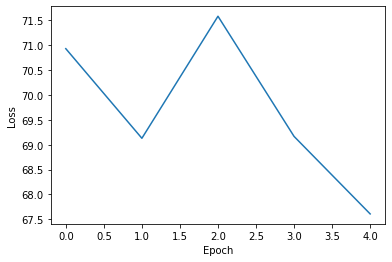

In [16]:
!mkdir -p ./tmp/conv
#But Training our model from scratch will take a long time
#So we will load a partially trained model to speedup the process 
conv_model.load_weights("conv_model.h5")

history = conv_model.fit(training_dataset, epochs=5, steps_per_epoch=train_batches,
          validation_data=validation_dataset, validation_steps=validation_batches, 
            callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/conv')])

data_utils.plot_keras_loss(history)
# not much improvement after 20 epochs, takes 25sec/epoch on v100

### Test

We will evaluate the model on the test dataset, and plot some of the results.

In [17]:
test_loss = conv_model.evaluate(test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 0s 33ms/step - loss: 55.4284
The loss over the test dataset 55.428409576416016


/workspace/python/source_code/utils/data_utils.py:45: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  stream_flow = h5py.File(filename)


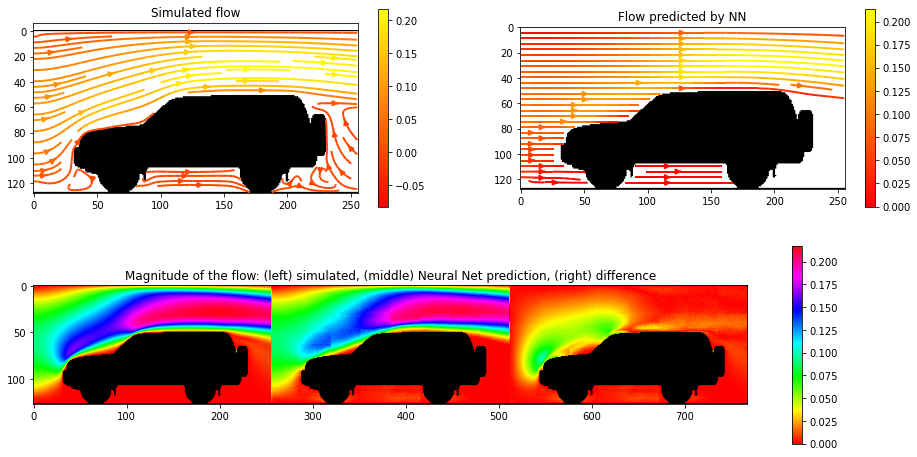

In [18]:
x, y = data_utils.load_test_data(1) # You can try different values between 1 and 28
y_hat = conv_model.predict(x)
data_utils.plot_test_result(x, y, y_hat)

# Input Data Manipulation

### Use signed distance function as the input feature

To improve the performance of the model, we will use a different encoding of the input data. Instead of giving 0s and 1s, we calculate the [signed distance function (SDF)](https://en.wikipedia.org/wiki/Signed_distance_function) of the input data.

Let $B$ denote the set of points inside solid objects, and $\partial B$ its boundary. We define $d(\vec{r},\partial B)$ as the distance between point $\vec{r}$ and the boundary $B$.

$$ d(\vec{r}, \partial B) = \min_{\vec{x} \in \partial B} | \vec{r} - \vec{x}|.$$

The signed distance function is defined as

$$\mathrm{SDF}(\vec{r}) = \begin{cases}
  -d(\vec{r}, \partial B) & \mbox{ if } \vec{r} \in B \\
   d(\vec{r}, \partial B)&  \mbox{ if } \vec{r} \notin B
\end{cases}$$


For every point in the grid, the SDF tells the distance to the closest boundary point. The plot below illustrates the SDF.

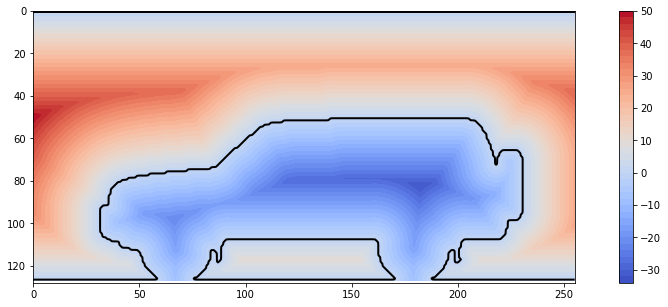

In [19]:
data_utils.plot_sdf(x[:,:,:], plot_boundary=True)

The following functions will create two new input files where the SDF is added as the second channel of the input data. Let it run for a minute.

In [20]:
data_utils.create_sdf_file('train')
data_utils.create_sdf_file('test')

100%|██████████| 28/28 [00:00<00:00, 35.88it/s]


Let's load our new dataset.

In [21]:
batch_size = 8
dataset_size = 1500   # Number of elements in the train.tfrecords
validation_size = 256 # Number of elements to use for validation

# derive some quantities
train_size = dataset_size - validation_size
train_batches = int(train_size / batch_size)
validation_batches= int(validation_size / batch_size)

test_size = 28
test_batches = int(test_size/batch_size)

def init_sdf_datasets():
    # Set up a dataset
    sdf_dataset = tf.data.TFRecordDataset('data/train_sdf.tfrecords')
    sdf_dataset = sdf_dataset.take(dataset_size)
    # Transform binary data into image arrays
    sdf_dataset = sdf_dataset.map(data_utils.parse_sdf_flow_data) 

    sdf_training_dataset = sdf_dataset.skip(validation_size).shuffle(buffer_size=512)
    sdf_training_dataset = sdf_training_dataset.batch(batch_size, drop_remainder=True)
    sdf_training_dataset = sdf_training_dataset.repeat()

    sdf_validation_dataset = sdf_dataset.take(validation_size).batch(batch_size, drop_remainder=True)
    sdf_validation_dataset = sdf_validation_dataset.repeat()

    # Read test dataset
    sdf_test_dataset = tf.data.TFRecordDataset('data/test_sdf.tfrecords')
    sdf_test_dataset = sdf_test_dataset.map(data_utils.parse_sdf_flow_data) # Transform binary data into image arrays
    sdf_test_dataset = sdf_test_dataset.batch(batch_size, drop_remainder = True).repeat()

    print('Number of batches in train/validation/test dataset:', train_batches, '/', validation_batches, '/', test_batches)
    return sdf_training_dataset,sdf_validation_dataset,sdf_test_dataset

We can visualize the the SDF for the training data : 

Number of batches in train/validation/test dataset: 155 / 32 / 3
input shape: [8, 128, 256, 2]
output shape: [8, 128, 256, 2]


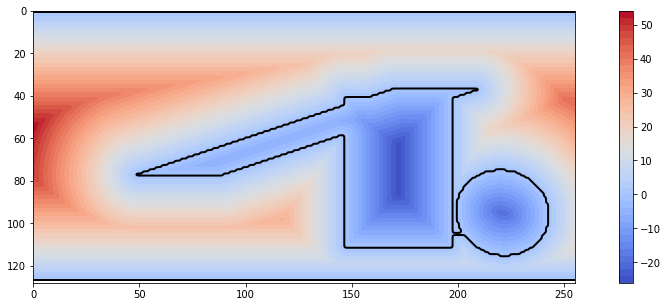

In [22]:
sdf_training_dataset, sdf_validation_dataset, sdf_test_dataset = init_sdf_datasets()
# Create an iterator for reading a batch of input and output data
iterator = iter(sdf_training_dataset)
boundary, vflow = next(iterator)
boundary, vflow = next(iterator)

print('input shape:', boundary.shape.as_list())
print('output shape:', vflow.shape.as_list())

plot_idx = 2 # set it between 0 and batch_size

data_utils.plot_sdf(boundary[plot_idx,:,:,0],boundary[plot_idx,:,:,1])

We can notice above that now our input data has 2 Channel holding boundary data and signed distance function respectively. 

We will use the boundary condition as a mask to remove flow lines in those areas.
So, let's modify the the convolutional network model to use the new SDF input feature

In [23]:
def conv_deconv_sdf(input):
    # Combine the convolution / deconvolution steps
    boundary = layers.Lambda(lambda x : x[:,:,:,0:1], name="boundary_slice")(input)
    sdf = layers.Lambda(lambda x : x[:,:,:,1:2], name="sdf_slice")(input)
    
    
    ### Calculate the encoding using the SDF
    x = conv(sdf)
    ###
    
    vx = deconv(x, "vx")
    
    # create a mask to zero out flow at (and inside) the boundary 
    vx = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_vx')([vx, boundary])
    
    vy = deconv(x, "vy")
    vy = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_vy')([vy, boundary])
    
    output = layers.concatenate([vx, vy], axis=3)
    
    return output

In [24]:
K.clear_session()

# we need to re-init the dacaset because of Clearing our session
sdf_training_dataset, sdf_validation_dataset, sdf_test_dataset = init_sdf_datasets()

# Define Input Outputs and Train the Model
input = tf.keras.Input(shape=(128,256,2), name="boundary")
output = conv_deconv_sdf(input)
conv_sdf_model = tf.keras.Model(inputs = input, outputs=output)
conv_sdf_model.compile(tf.keras.optimizers.Adam(0.0001), loss=loss_image)
conv_sdf_model.summary()

Number of batches in train/validation/test dataset: 155 / 32 / 3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
boundary (InputLayer)           [(None, 128, 256, 2) 0                                            
__________________________________________________________________________________________________
sdf_slice (Lambda)              (None, 128, 256, 1)  0           boundary[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 8, 16, 128)   32896       sdf_slice[0][0]                  
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 2, 4, 512)    1049088     conv1[0][0]                      
_____________________________

Epoch 1/5
155/155 [==============================] - 16s 93ms/step - loss: 74.7470 - val_loss: 79.6756
Epoch 2/5
155/155 [==============================] - 14s 91ms/step - loss: 68.8094 - val_loss: 80.3380
Epoch 3/5
155/155 [==============================] - 14s 91ms/step - loss: 70.8779 - val_loss: 82.4137
Epoch 4/5
155/155 [==============================] - 14s 91ms/step - loss: 69.8980 - val_loss: 78.2314
Epoch 5/5
155/155 [==============================] - 14s 91ms/step - loss: 68.4638 - val_loss: 78.4795


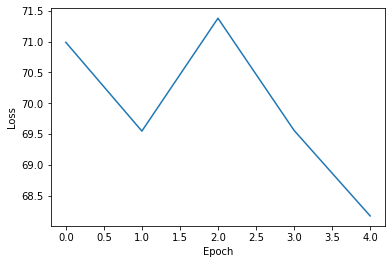

In [25]:
#But Training our model from scratch will take a long time
#So we will load a partially trained model to speedup the process 
conv_sdf_model.load_weights("conv_sdf_model.h5")

history = conv_sdf_model.fit(sdf_training_dataset, epochs=5, steps_per_epoch=train_batches,
          validation_data=sdf_validation_dataset, validation_steps=validation_batches)

# Plot Training data
data_utils.plot_keras_loss(history)

### Test

In [26]:
test_loss = conv_sdf_model.evaluate(sdf_test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 0s 33ms/step - loss: 53.9632
The loss over the test dataset 53.96318435668945


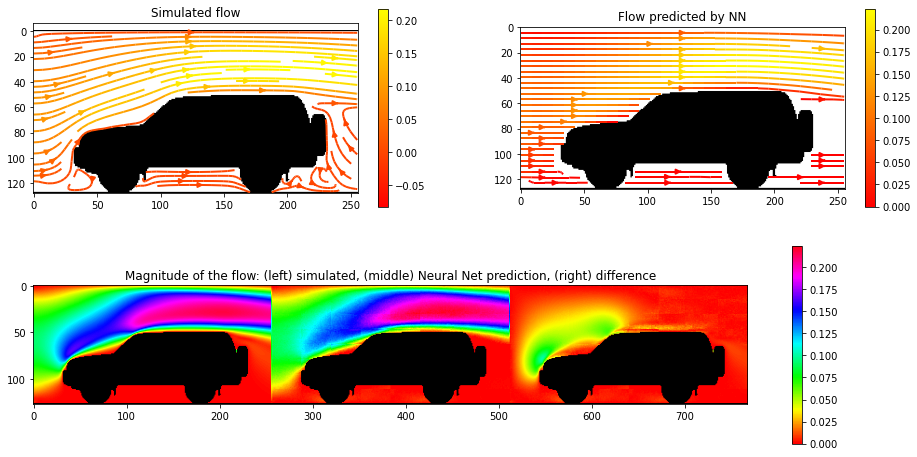

In [27]:
x, y = data_utils.load_test_data(1) # You can try different values between 1 and 28
sdf = np.reshape(data_utils.calc_sdf(x[0,:,:,0]),(1,x.shape[1], x.shape[2],1))
x = np.concatenate((x, sdf), axis=3)
y_hat = conv_sdf_model.predict(x)
data_utils.plot_test_result(x[:,:,:,0:1], y, y_hat)

We find the Signed distance function performed better than the Boundary defined input. Let us understand why this is the case:

From the Research paper : 

```
Geometry can be represented in multiple ways, such as boundaries and geometric parameters. However, those               representations are not effective for neural networks since the vectors' semantic meaning varies.
```

```
The values of SDF on the sampled Cartesian grid not only provide local geometry details but also contain additional     information of the global geometry structure.
```

To put the above in simple words, when our Convolution neural networks learn, we have seen that it also convolutes over an area of the set kernel size where it takes the considerations of the neighbouring pixels and not just a single pixel, this makes the signed distance function a rightful choice as it assigns values to all the pixels in the input image.

In the upcoming notebook, let us introduce some advance networks and train them.

## Important:
<mark>Shutdown the kernel before clicking on “Next Notebook” to free up the GPU memory.</mark>


## License

This material is released by OpenACC-Standard.org, in collaboration with NVIDIA Corporation, under the Creative Commons Attribution 4.0 International (CC BY 4.0).

[Previous Notebook](Part2.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[1](Start_Here.ipynb)
[2](Part2.ipynb)
[3]
[4](Part4.ipynb)
[5](Competition.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[Next Notebook](Part4.ipynb)


&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&ensp;
[Home Page](../Start_Here.ipynb)
